In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import ast

movies = pd.read_csv("movie_data.csv")

C:\Users\jacobmcc\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


The next cell was used before I found the literal_eval method from ast which converts strings that are in the format of lists into actual lists.

In [2]:
# def genre_cleaner(row):
#     genre_string = row['genres']
#     genre_string = genre_string.replace(',','').replace('"','')
#     #We lower just in case there is variability in capatalization convention
#     genre_list = genre_string.strip("[]").lower().split()
#     return genre_list

# #Here we reassign genre column. We change the original dataset as there is no reason to keep old format
# movies['genres'] = movies.apply(lambda row: genre_cleaner(row), axis = 1)

In [3]:
movies['genres'] = pd.Series(ast.literal_eval(genres) for genres in movies['genres'])

In [4]:
print(movies.notnull().sum())
print("...")
print("Number of movies: ", len(movies))

id                    42204
title                 42204
release_date          39586
box_office_revenue     7587
runtime               35580
genres                42204
summary               42204
dtype: int64
...
Number of movies:  42204


Here we split by genres so each instance of a movie has a row for a given title. This allows us to more easily work with the data and ask questions of the genre-centric questions of the data.

In [5]:
all_genres = np.hstack(movies.genres)
all_titles = np.hstack([[title]*len(genre) for title, genre in movies[['title', 'genres']].values])
all_release_dates = np.hstack([[release]*len(genre) for release, genre in movies[['release_date', 'genres']].values])
all_revenues = np.hstack([[revenue]*len(genre) for revenue, genre in movies[['box_office_revenue', 'genres']].values])
all_runtimes = np.hstack([[runtime]*len(genre) for runtime, genre in movies[['runtime', 'genres']].values])
all_summaries = np.hstack([[summary]*len(genre) for summary, genre in movies[['summary', 'genres']].values])

movies_expanded = pd.DataFrame({'genres':all_genres, 'titles':all_titles, 'release_date':all_release_dates,
                     'box_office_revenue':all_revenues, 'runtime':all_runtimes, 'summary':all_summaries})

movies_expanded.head(10)

,box_office_revenue,genres,release_date,runtime,summary,titles
0,14010832.0,Space western,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
1,14010832.0,Horror,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
2,14010832.0,Supernatural,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
3,14010832.0,Thriller,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
4,14010832.0,Science Fiction,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
5,14010832.0,Action,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
6,14010832.0,Adventure,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
7,NaN,Erotic thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
8,NaN,Psychological thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
9,NaN,Thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye


In [6]:
# movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).describe()['about']
med = movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).median().nlargest(20)
med

genres
Coming-of-age film                          531957538.0
Space opera                                 475106177.0
Movies About Gladiators                     457640427.0
Archaeology                                 401128639.0
Educational                                 399755374.0
Reboot                                      385494555.0
Revisionist Fairy Tale                      350367551.5
Humour                                      331950002.0
Point of view shot                          248639099.0
Computer Animation                          233366379.5
Sci-Fi Thriller                             214796484.5
Archives and records                        209701562.5
Period Horror                               206071502.0
Sci-Fi Adventure                            196567262.0
Private military company                    171407179.0
Glamorized Spy Film                         160000000.0
Apocalyptic and post-apocalyptic fiction    157091718.0
Master Criminal Films                    

In [7]:
unique_genres = list(set(x for x in movies_expanded['genres']))
len(unique_genres)

363

Looking at the set of genres we can see there are many genres that are the same for all intents and purposes just spelled slightly differently or are synonyms to other genres.

In the next cell we show the use of two functions from the package fuzzy wuzzy. This module will help us identify opportunities to aggregate genres.

In [8]:
#Need to go into more detail here...

print(fuzz.partial_ratio("family", "family-oriented"))
print(fuzz.ratio("family", "family-oriented"))
print(fuzz.ratio("educational", "education"))

100
57
90


In [12]:
unique_genres = list(set(x for x in movies_expanded['genres']))

temp_mapper = {genre : [] for genre in unique_genres}

for i in range(len(unique_genres)):
    for j in range(len(unique_genres)):
        if i != j:
            ratio_score = fuzz.ratio(unique_genres[i],unique_genres[j])
            partial_score = fuzz.partial_ratio(unique_genres[i],unique_genres[j])
            if ratio_score >= 85 or partial_score == 100:
                temp_mapper[unique_genres[i]].append(unique_genres[j])
#temp_mapper     

genre_mapper = {"Action": "Action/Adventure", "Adventure": "Action/Adventure", "Music": "Musical",
               "Computer Animation": "Animation", "Animated Cartoon": "Animation", "Backstage Musical": "Musical",
               "Beach Party film": "Beach Film", "Biographical Film": "Biography", "Biopic [feature]": "Biography",
               "Breakdance": "Dance", "Alien invasion": "Alien Film", "Children\'s/Family": "Children\'s",
               "Children\'s Entertainment": "Children\'s", "Children\'s Fantsy": "Children\'s", 
               "Children\'s Issues": "Children\'s", "Comdedy": "Comedy", "Comedy horror": "Horror Comedy",
               "Comedy film": "Comedy", "Coming-of-age film": "Coming of age", "Detective Fiction": "Detective",
               "Education": "Educational", "Extreme Sports": "Sports", "Gross-out film": "Gross out",
               "World History": "History", "Humour": "Comedy", "Monster movie": "Monster", "Prison film": "Prison",
               "Superhero movie": "Superhero", "Sword and sorcery films": "Sword and sorcery"}

# genre_mapper = {}

# for key, value in temp_mapper.items():
#     if len(value) > 0:
#         genre_mapper[key] = value

# genre_mapper = {}

# genre_mapper = {'action': 'action/adventure', 'adventure': 'action/adventure', 'age':'coming-of-age',
#                'animal': 'animals', 'art': 'arts', 'child': 'children\'s/family', 'children\'s': 'children\'s/family',
#                'comdedy': 'comedy', 'humour': 'comedy', 'computers': 'computer', 'breakdance': 'dance', 
#                'documetary': 'documentary', 'education': 'educational', 'homoeroticism': 'erotic', 'erotica': 'erotic',
#                'family': 'children\'s/family', 'family-oriented': 'children\'s/family', 'fantasies': 'fantasy',
#                'fictional': 'fiction', 'gross-out': 'gross', 'investing': 'finance', 'film-opera': 'opera',
#                'pictures': 'picture', 'thrillers': 'thriller'}

#Here we use the mapping we just created to replace like genres
movies_expanded['genres'].replace(genre_mapper, inplace = True)
movies_expanded = movies_expanded.drop_duplicates()
movies_expanded.head(10)

,box_office_revenue,genres,release_date,runtime,summary,titles
0,14010832.0,Space western,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
1,14010832.0,Horror,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
2,14010832.0,Supernatural,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
3,14010832.0,Thriller,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
4,14010832.0,Science Fiction,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
5,14010832.0,Action/Adventure,2001-08-24,98.0,"Set in the second half of the 22nd century, th...",Ghosts of Mars
7,NaN,Erotic thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
8,NaN,Psychological thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
9,NaN,Thriller,1987,110.0,A series of murders of rich young women throug...,White Of The Eye
10,NaN,Drama,1983,106.0,"Eva, an upper class housewife, becomes frustra...",A Woman in Flames


In [16]:
#movies_expanded['genres'].groupby(movies_expanded['genres']).count().nlargest(50)

In [20]:
horror_revenue = movies_expanded[movies_expanded['genres'] == 'Horror']['box_office_revenue'].dropna()

comedy_revenue = movies_expanded[movies_expanded['genres'] == 'Comedy']['box_office_revenue'].dropna()

drama_revenue = movies_expanded[movies_expanded['genres'] == 'Drama']['box_office_revenue'].dropna()


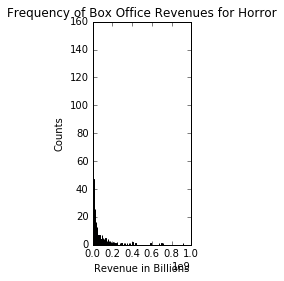

In [24]:
horror_revenue = movies_expanded[movies_expanded['genres'] == 'Horror']['box_office_revenue'].dropna()

plt.subplot(1,3,1)
plt.hist(horror_revenue, bins = round(0.5*len(horror_revenue)))
plt.title("Frequency of Box Office Revenues for Horror")
plt.ylabel("Counts")
plt.xlabel("Revenue in Billions")
plt.show()

#print(sorted(movies_expanded[movies_expanded['genres'] == 'horror']['box_office_revenue'].dropna(), reverse = True))

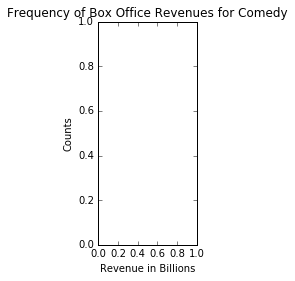

In [25]:
plt.hist(horror_revenue, bins = round(0.5*len(comedy_revenue)))
plt.subplot(1,3,2)
plt.title("Frequency of Box Office Revenues for Comedy")
plt.ylabel("Counts")
plt.xlabel("Revenue in Billions")
plt.show()

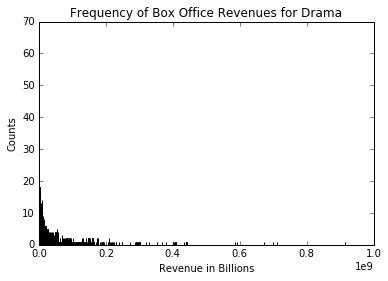

In [23]:
plt.hist(horror_revenue, bins = round(0.5*len(drama_revenue)))
plt.subplot(1,3,3)
plt.title("Frequency of Box Office Revenues for Drama")
plt.ylabel("Counts")
plt.xlabel("Revenue in Billions")
plt.show()

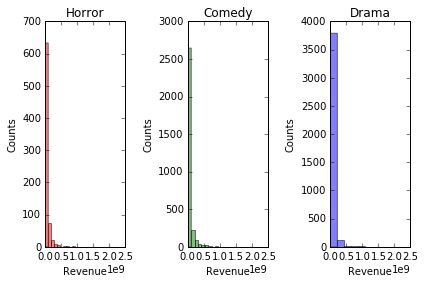

In [60]:
fig, ax = plt.subplots(1,3, sharex=True)

ax[0].hist(horror_revenue, alpha = 0.5, color = 'r')
ax[0].set_title('Horror')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel("Revenue")

ax[1].hist(comedy_revenue, alpha = 0.5, color = 'g')
ax[1].set_title('Comedy')
ax[1].set_ylabel("Counts")
ax[1].set_xlabel("Revenue")

ax[2].hist(drama_revenue, alpha = 0.5, color = 'b')
ax[2].set_title('Drama')
ax[2].set_ylabel("Counts")
ax[2].set_xlabel("Revenue")

plt.tight_layout()
plt.show()

Taking a look at the plots above we can see that the vast majority of box office revenues are found at the lower end of the range. Also we see that for each genre plotted there are a few significant outliers which indicates that the mean will be greatly affected by these outliers. Because of this we assume that either median or genre-count are better overall descriptions of popularity via box office revenue.

In [80]:
top20_median = movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).median().nlargest(20)
top20_count = movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).count().nlargest(20)
top20_mean = movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).mean().nlargest(20)

# print(top20_median)
# print(top20_count)
# print(top20_mean)

#movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).count().nlargest(122)

#print(set(top20_count.index) & set(top20_median.index))
def top_n_median(n):
    return movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).median().nlargest(n)

#Let's take a look at the top 20 genres and see if they align with out intuition (i.e. Comedy/Drama/etc...)
top_n_median(20)

genres
Space opera                                 475106177.0
Movies About Gladiators                     457640427.0
Archaeology                                 401128639.0
Educational                                 399755374.0
Reboot                                      385494555.0
Revisionist Fairy Tale                      350367551.5
Point of view shot                          248639099.0
Sci-Fi Thriller                             214796484.5
Archives and records                        209701562.5
Period Horror                               206071502.0
Sci-Fi Adventure                            196567262.0
Private military company                    171407179.0
Glamorized Spy Film                         160000000.0
Apocalyptic and post-apocalyptic fiction    157091718.0
Master Criminal Films                       152945555.5
Auto racing                                 151027274.5
Live action                                 148947455.0
Buddy cop                                

This does not match our intuition whatsoever! I have never heard of anyone going to a "Space Opera, which certainly wouldn't be true for the actual most popular genre.

(array([ 319.,   11.,    3.,    2.,    1.,    0.,    1.,    0.,    0.,    1.]),
 array([  -429.96745562,   1483.33254438,   3396.63254438,   5309.93254438,
          7223.23254438,   9136.53254438,  11049.83254438,  12963.13254438,
         14876.43254438,  16789.73254438,  18703.03254438]),
 <a list of 10 Patch objects>)

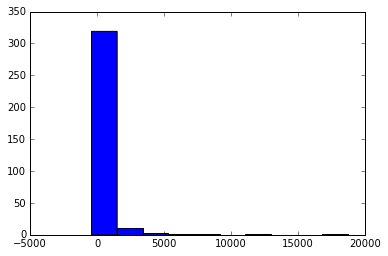

In [86]:
genre_count_df = movies_expanded.groupby(["genres"]).size().reset_index(name="genre_count")
#movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).count().nlargest(20)
m = np.mean(genre_count_df['genre_count'])
centered = genre_count_df['genre_count'] - m
plt.hist(centered)

Only like the top 120 genres in terms of count have a sample size > 30. We should only pick from that list.

In [42]:
# print(movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).mean().nlargest(20))
# print(movies_expanded['genres'].groupby(movies_expanded['genres']).count().nlargest(20))
print(movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).count().nlargest(20))

mean_set = set(movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).mean().nlargest(100).index)
count_set = set(movies_expanded['genres'].groupby(movies_expanded['genres']).count().nlargest(100).index)
print(mean_set & count_set)

genres
drama                5684
film                 5368
comedy               5295
action/adventure     4618
thriller             3151
fiction              1978
crime                1924
romance              1863
children's/family    1705
romantic             1556
fantasy              1037
indie                 946
horror                881
mystery               652
science               632
period                617
piece                 616
musical               606
cinema                589
adaptation            566
Name: box_office_revenue, dtype: int64
{'action/adventure', 'buddy', 'fantasy', 'story', 'epic', 'movie', 'fiction', 'computer', 'natural', 'animation', 'science', "children's/family", 'spy', 'and', 'monster', 'superhero', 'sci-fi', 'costume', 'historical', 'disaster', 'films'}


In [49]:
print(movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).mean().nlargest(20))
print("...")
print(movies_expanded['box_office_revenue'].groupby(movies_expanded['genres']).count().nlargest(150))

genres
nature              5.570175e+08
reboot              4.301287e+08
archaeology         4.011286e+08
educational         3.997554e+08
about               3.704296e+08
gladiators          3.704296e+08
opera               3.462949e+08
computer            3.145635e+08
school              3.113077e+08
point               2.486391e+08
shot                2.486391e+08
view                2.486391e+08
vampire             2.474483e+08
fairy               2.449851e+08
tale                2.449851e+08
apocalyptic         2.439320e+08
post-apocalyptic    2.439320e+08
space               2.406139e+08
archives            2.273847e+08
records             2.273847e+08
Name: box_office_revenue, dtype: float64
...
genres
drama                5684
film                 5368
comedy               5295
action/adventure     4618
thriller             3151
fiction              1978
crime                1924
romance              1863
children's/family    1705
romantic             1556
fantasy              

In [ ]:
unique_genres

In [ ]:
#Keep this in mind as it would just create a rank column automatically
#df["rank"] = df.groupby("group_ID")["value"].rank("dense", ascending=False)

#We could also just look at how many times each genre appeared in our dataframe. The idea being that
#    the more instances of a given genre the more those genres get made - assuming our sample is an ok representation
#    of the population of movies. The more movies that get made in a given genre the more popular they are.

In [6]:
movies

,id,title,release_date,box_office_revenue,runtime,genres,summary
0,0,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[space, western, horror, supernatural, thrille...","Set in the second half of the 22nd century, th..."
1,1,White Of The Eye,1987,NaN,110.0,"[erotic, thriller, psychological, thriller, th...",A series of murders of rich young women throug...
2,2,A Woman in Flames,1983,NaN,106.0,[drama],"Eva, an upper class housewife, becomes frustra..."
3,3,The Sorcerer's Apprentice,2002,NaN,86.0,"[adventure, fantasy, world, cinema, family, film]","Every hundred years, the evil Morgana returns..."
4,4,Little city,1997-04-04,NaN,93.0,"[romance, film, ensemble, film, comedy-drama, ...","Adam, a San Francisco-based artist who works a..."
5,5,Henry V,1989-11-08,10161099.0,137.0,"[epic, war, film, costume, drama, drama, perio...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
6,6,Aaah Belinda,1986,NaN,NaN,[comedy],"Serap, a young actress with a strong, lively p..."
7,7,The Mechanical Monsters,NaN,NaN,NaN,"[short, film, science, fiction, family, film, ...",The story starts as one of the robots flies i...
8,8,Mary Poppins,1964-08-27,102272727.0,139.0,"[children's/family, children's, fantasy, comed...",The film opens with Mary Poppins perched in a...
9,9,Die Fahne von Kriwoj Rog,1967,NaN,108.0,[],"Otto Brosowski, a communist miner, writes to t..."
